In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from uuid import uuid4
import numpy as np
import tracemalloc

In [2]:
df = pd.read_csv('logs/r6-matches.log', header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'])

In [3]:
df.shape

(55833, 4)

In [4]:
df.isnull().sum()

player_id      0
match_id       0
operator_id    0
nb_kills       0
dtype: int64

In [5]:
operators = df.operator_id.unique()
operators.sort()
operators

array([ 14,  24,  30,  46,  64,  72,  73,  84, 100, 107, 109, 112, 130,
       132, 173, 193, 194, 211, 230, 233, 237, 241, 245, 253])

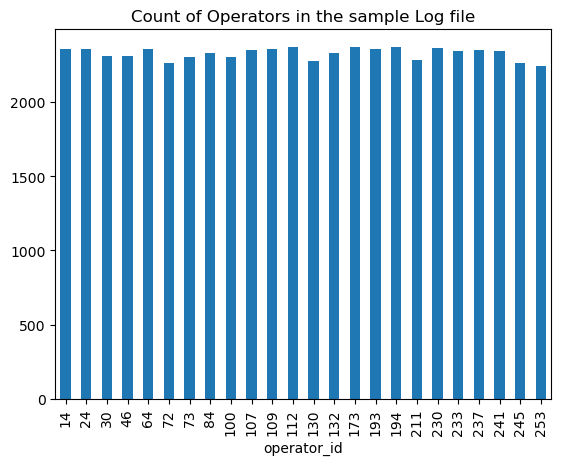

In [6]:
df.operator_id.value_counts().sort_index().plot(kind='bar', title='Count of Operators in the sample Log file')
plt.show()

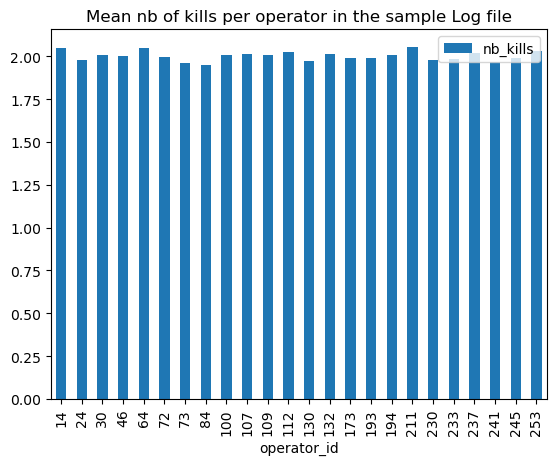

In [7]:
operators_mean_kills = df[['operator_id', 'nb_kills']].groupby('operator_id').mean()
operators_mean_kills.sort_values(by='nb_kills')
operators_mean_kills.plot(kind='bar', title='Mean nb of kills per operator in the sample Log file')
plt.show()

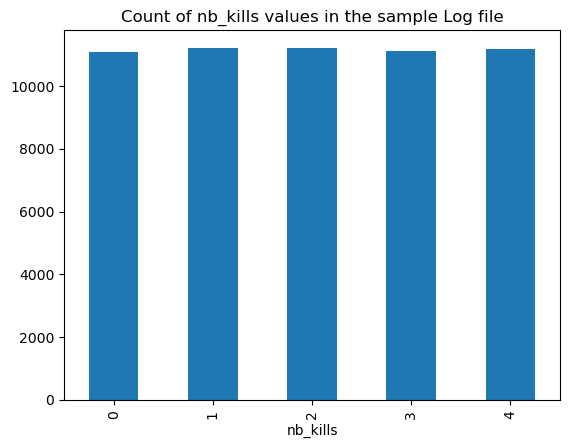

In [8]:
df.nb_kills.value_counts().sort_index().plot(kind='bar', title='Count of nb_kills values in the sample Log file')
plt.show()

In [9]:
len(df.match_id.unique())

1000

In [13]:
len(df['player_id'].unique())

100

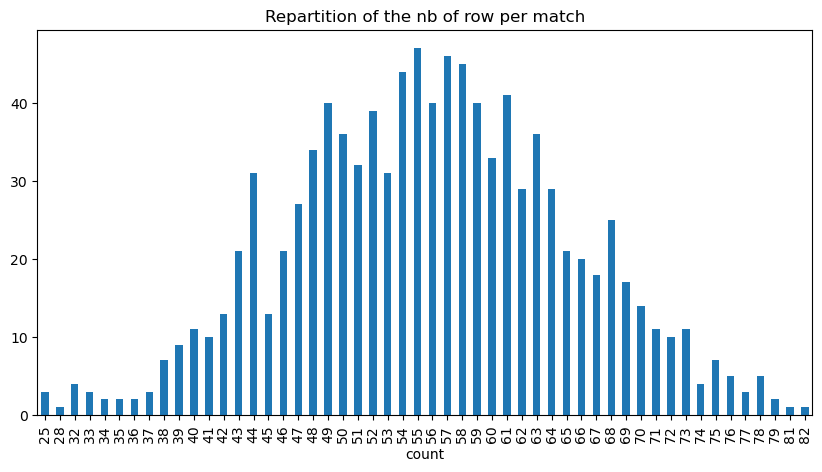

In [10]:
nb_row_per_match = df.match_id.value_counts()

nb_row_per_match_distribution = nb_row_per_match.value_counts().sort_index()

plt.figure(figsize=(10,5))

nb_row_per_match_distribution.plot(kind='bar', title='Repartition of the nb of row per match')
plt.show()

In [11]:
mu = np.mean(nb_row_per_match.values)
std = np.std(nb_row_per_match.values)

print(f'Average nb of row per match: {mu}')
print(f'Std nb of row per match: {std}')

Average nb of row per match: 55.833
Std nb of row per match: 9.328189052543907


In [12]:
df.groupby('match_id')['player_id'].nunique().value_counts()

player_id
10    1000
Name: count, dtype: int64

Its confirmed that all match have 10 players.

In [15]:
def generate_matchs(n_matchs:int): 
    """
    Generate a DataFrame containing simulated match data for a gaming scenario.

    This function creates a DataFrame representing match records, including player IDs, match IDs,
    operator IDs, and the number of kills for each entry. The number of matches is specified by 
    the user, and the function randomly generates additional data based on defined distributions 
    and parameters.

    Parameters:
    -----------
    n_matchs : int
        The number of matches to simulate. Each match will have a varying number of rows 
        (gameplay entries) based on a normal distribution, constrained within specified 
        boundaries.

    Returns:
    --------
    pd.DataFrame
        A pandas DataFrame containing the following columns:
        - 'player_id': A unique identifier for each player involved in the matches.
        - 'match_id': A unique identifier for each match played.
        - 'operator_id': The operator chosen by the player during the match.
        - 'nb_kills': The number of kills achieved by the player in that match.

    Notes:
    ------
    - If n_matchs is less than or equal to zero, an empty DataFrame is returned with the defined 
      column names.
    - The number of players available for selection is calculated as a ratio of the number of matches,
      with a minimum of 10 players.
    - The function generates match records with an average number of rows per match set at 55.833,
      with a standard deviation of approximately 9.33. The number of rows per match is clipped 
      between a minimum of 25 and a maximum of 82 to ensure reasonable gameplay scenarios.
    - Player IDs are generated as UUIDs, while operator IDs are randomly selected from a predefined
      list of operator values.
    - **Warning**: Generating a very high number of matches (e.g., 1,000,000) may lead to high memory usage,
      potentially causing your system to freeze, especially on machines with limited RAM (e.g., 8 GB). 
      It is recommended to test with smaller values first and considere batch generation.

    Example:
    ---------
    >>> df = generate_matchs(1000)
    >>> print(df.head())
    """
    if n_matchs <= 0: 
        return pd.DataFrame({}, columns=['player_id', 'match_id', 'operator_id', 'nb_kills']) 
    
    nb_players_per_match = 10
    nb_players_ratio = 0.1  # 100/1000
    nb_players = max(nb_players_per_match, round(nb_players_ratio * n_matchs))

    match_nb_of_rows_low_boundary = 25
    match_nb_of_rows_high_boundary = 82

    players = [ str(uuid4()) for _ in range(nb_players) ] 
    matchs = [ str(uuid4()) for _ in range(n_matchs) ] 

    operators = np.array([14, 24, 30, 46, 64, 72, 73, 84, 100, 107, 109, 112, 130, 132, 173, 193, 194, 211, 230, 233, 237, 241, 245, 253])

    avg_nb_row_per_match = 55.833
    std_nb_row_per_match = 9.328189052543907

    match_nb_of_rows_all = np.clip(
        np.random.normal(avg_nb_row_per_match, std_nb_row_per_match, size=n_matchs), 
        match_nb_of_rows_low_boundary, 
        match_nb_of_rows_high_boundary
    ).astype(int)

    total_rows = match_nb_of_rows_all.sum()
    
    match_ids = np.empty(total_rows, dtype='U36')  # For UUID match_ids
    player_ids = np.empty(total_rows, dtype='U36')  # For UUID player_ids
    operator_ids = np.empty(total_rows, dtype=np.int32)
    nb_kills = np.empty(total_rows, dtype=np.int32)

    current_idx = 0
    
    for i, match_id in enumerate(matchs): 

        match_nb_of_rows = match_nb_of_rows_all[i]

        # matchs: 1000
        # players: 100
        # match = 10 => 100 -> 109 (out of bounce) => 0 -> 9 = (i%10)*10 -> (i%10) + 1 * 10
        match_players = players[(i%10)*10: ((i%10) + 1) * 10]
        

        sequence_players = np.random.choice(match_players, size=match_nb_of_rows, replace=True) 
        
        sequence_operators = np.random.choice(operators, size=match_nb_of_rows, replace=True)
        sequence_nb_kills = np.random.randint(0, 5, size=match_nb_of_rows)

        match_ids[current_idx:current_idx + match_nb_of_rows] = match_id
        player_ids[current_idx:current_idx + match_nb_of_rows] = sequence_players
        operator_ids[current_idx:current_idx + match_nb_of_rows] = sequence_operators
        nb_kills[current_idx:current_idx + match_nb_of_rows] = sequence_nb_kills

        current_idx += match_nb_of_rows

    matchs_df = pd.DataFrame({
        'player_id': player_ids,
        'match_id': match_ids,
        'operator_id': operator_ids,
        'nb_kills': nb_kills
    })

    return matchs_df

In [16]:
%timeit -r 5 -n 3 matchs = generate_matchs(10**4)

857 ms ± 19.6 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [17]:
%time matchs_100k = generate_matchs(10 ** 5)

CPU times: user 7.02 s, sys: 1.35 s, total: 8.36 s
Wall time: 8.37 s


In [18]:
from pathlib import Path

path = Path('logs/100k_matchs.log')

if not path.exists():

    matchs_100k = generate_matchs(10 ** 5)

    path.parent.mkdir(parents=True, exist_ok=True)

    file = path.open(mode='w')

    matchs_100k.to_csv(file, index=False, header=False)

In [20]:
def print_peak_memory_MB(function):
    def sub_func(*args, **kwargs):     
        tracemalloc.start()
        res = function(*args, **kwargs)

        _, peak = tracemalloc.get_traced_memory()
        tracemalloc_memory = tracemalloc.get_tracemalloc_memory()

        tracemalloc.stop()
        function_peak_memory_usage = peak - tracemalloc_memory

        print(f'Peak Memory Usage {function_peak_memory_usage / (1024**2)} MB')
        return res
    return sub_func

In [21]:
@print_peak_memory_MB
def load_100k_matchs(): 
    return pd.read_csv('logs/100k_matchs.log', header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'])

load_100k_matchs().head()

Peak Memory Usage 392.84739112854004 MB


,player_id,match_id,operator_id,nb_kills
0,0b4357cd-e759-4ae4-bf8b-3b871a1f30b6,56402e35-9f17-47f7-93ad-b6f7873c9cf2,30,4
1,1f3caea6-2221-41d8-96e5-e0829a1ed6b6,56402e35-9f17-47f7-93ad-b6f7873c9cf2,132,2
2,c9a1c334-d0e9-48e7-9343-6b6267946c75,56402e35-9f17-47f7-93ad-b6f7873c9cf2,100,2
3,fcdec4b8-e300-4853-bcab-d6804a7da243,56402e35-9f17-47f7-93ad-b6f7873c9cf2,30,3
4,8405b035-7af9-49ab-90a0-ed2d637bd18e,56402e35-9f17-47f7-93ad-b6f7873c9cf2,194,0


operator_top100_YYYYMMDD.txt (both on the last 7 days.)

operator_id|match_id1:avg_kills1,match_id2:avg_kills2,...,match_id100:avg_kills100 

In [23]:
def top_100_average_kills_per_operator(df: pd.DataFrame): 
    return (
        df.groupby(
            ['operator_id', 'match_id']
        )['nb_kills']
        .mean()
        .reset_index()
        .sort_values(
            by=['operator_id', 'nb_kills'], 
            ascending=[True, False]
        )
        .groupby(
            by='operator_id'
        )
        .head(100)
    )

# a vérifier si c'est vraiment ce qui est demandé dans l'énoncé
def top_10_best_matchs_per_player(df: pd.DataFrame): 
    return (
        df.groupby(
            by=['player_id', 'match_id']
        )['nb_kills']
        .sum()
        .reset_index()
        .sort_values(
            by=['player_id', 'nb_kills'],
            ascending=[True, False]
        )
        .groupby(
            by='match_id'
        ).head(10)
    )

top_100_average_kills_per_operator(df)

,operator_id,match_id,nb_kills
3,14,0240b2df-ba89-4a1a-b491-a3c34a9e9c86,4.000000
7,14,034e52a5-243e-4174-8142-488a47946814,4.000000
17,14,055b422d-f92e-4ea3-a159-4d7589ae9cea,4.000000
21,14,0644773a-b238-49ea-800c-2f8460cb09ce,4.000000
41,14,0beeb9db-9c3a-448e-ab81-6f6ae59681cc,4.000000
...,...,...,...
21874,253,8e4d7289-df12-4f38-b0b4-41047582380d,3.333333
21877,253,8f3e31e7-d163-4668-abf9-0b90830e975a,3.333333
22022,253,b941313b-f803-45ba-b5da-d761cb1e4bbc,3.333333
22163,253,e0330044-ef28-4c63-a352-2452650800a3,3.333333


In [43]:
matchs_100k = load_100k_matchs()
rows, cols = matchs_100k.shape

print(f'100k matchs represent arround {rows//(10 ** 6)}M and {(rows % (10 ** 6))//(10**5) }00k rows')

Peak Memory Usage 392.848295211792 MB
100k matchs represent arround 5M and 500k rows


In [29]:
@print_peak_memory_MB
def compute_metrics(path: str): 
    df = pd.read_csv(path, header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'])

    top_avg_kills = top_100_average_kills_per_operator(df)
    # top_best_matchs = top_10_best_matchs_per_player(df)

    return top_avg_kills

top_avg_kills = compute_metrics('logs/100k_matchs.log')

Peak Memory Usage 523.5749797821045 MB


100k matchs seems managable under 1Go of RAM ~ 530 MB RAM

In [23]:
chunksize = 10 ** 5

chunked_df = pd.read_csv('logs/test.log', header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'], chunksize=chunksize)

In [24]:
type(chunked_df)

pandas.io.parsers.readers.TextFileReader

In [25]:
chunk = chunked_df.get_chunk()

In [26]:
type(chunk)

pandas.core.frame.DataFrame

In [27]:
import tempfile
def store_tempfile(df:pd.DataFrame): 

    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as temp_file:
        df.to_csv(temp_file, index=False, header=True)
        temp_file_path = temp_file.name

        return temp_file_path

In [28]:
temp_file_path = store_tempfile(top_100_average_kills_per_operator(chunk))

In [29]:
pd.read_csv(temp_file_path)

,operator_id,match_id,nb_kills
0,14,0240b2df-ba89-4a1a-b491-a3c34a9e9c86,4.0
1,14,034e52a5-243e-4174-8142-488a47946814,4.0
2,14,055b422d-f92e-4ea3-a159-4d7589ae9cea,4.0
3,14,0644773a-b238-49ea-800c-2f8460cb09ce,4.0
4,14,07d730b7-bed7-438a-967d-04b568334b05,4.0
...,...,...,...
2395,253,cbe05160-7e05-4922-aa0e-74d1b0b0b7ca,4.0
2396,253,cf15539c-999a-4a72-8534-3b2397a9d4c2,4.0
2397,253,d1a65a56-e25e-4c29-a2cf-b274174efbf2,4.0
2398,253,d3a823d6-ae68-4d56-87e0-0d12bb1e8d67,4.0
